In [1]:
%load_ext autoreload
%autoreload 2

%pip install -r ../../requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np

import xgboost as xg
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import root_mean_squared_error
import shap

/Users/luisangel/Documents/Datathon2024/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [38]:
year = "2023"
flights = pd.read_parquet("../../resources/flights_clean.parquet")
flights = flights.astype({"Passengers": "int16", "Bookings": "int16"})
flights.head()

,Flight_ID,Aeronave,DepartureStation,ArrivalStation,Destination_Type,Origin_Type,STD,STA,Capacity,Passengers,Bookings,Mes,Semana,DiaSemana,Hora
0,ab954014077430bd842cfa305a55c0f8,XA-VBY,AT,AZ,Ciudad Fronteriza,Ciudad Principal,2023-10-19 11:40:00,2023-10-19 14:25:00,240,229,157,10,42,4,11
1,efd86c996035dacdca7a0ccb2560dda1,XA-VIX,BM,AV,MX Amigos y Familia,Ciudad Fronteriza,2023-07-03 00:55:00,2023-07-03 04:55:00,186,197,109,7,27,1,0
2,dd0fad3248951d2f71d63e6279aeaa4b,XA-VBW,AW,AS,MX Amigos y Familia,Ciudad Principal,2023-06-26 15:15:00,2023-06-26 15:55:00,220,200,142,6,26,1,15
3,d0987ee648eea254063bfe2b39571b67,XA-VAP,BA,AB,Playa,Ciudad Principal,2023-02-10 08:40:00,2023-02-10 09:50:00,186,162,90,2,6,5,8
4,3b5df8805161ea827d2f2e4298c38e06,XA-VBY,AJ,AR,Playa,MX Amigos y Familia,2023-09-07 17:10:00,2023-09-07 18:05:00,240,183,125,9,36,4,17


La variable real a predecir el modelo es la cantida de pasajeros de un vuelo individual

In [4]:
y = flights["Passengers"]
y.head()

0    229
1    197
2    200
3    162
4    183
Name: Passengers, dtype: int16

---

In [5]:
X = flights.drop(columns=["Passengers", "Flight_ID", "STA"])
X.head()

,Aeronave,DepartureStation,ArrivalStation,Destination_Type,Origin_Type,STD,Capacity,Bookings,Mes,Semana,DiaSemana,Hora
0,XA-VBY,AT,AZ,Ciudad Fronteriza,Ciudad Principal,2023-10-19 11:40:00,240,157,10,42,4,11
1,XA-VIX,BM,AV,MX Amigos y Familia,Ciudad Fronteriza,2023-07-03 00:55:00,186,109,7,27,1,0
2,XA-VBW,AW,AS,MX Amigos y Familia,Ciudad Principal,2023-06-26 15:15:00,220,142,6,26,1,15
3,XA-VAP,BA,AB,Playa,Ciudad Principal,2023-02-10 08:40:00,186,90,2,6,5,8
4,XA-VBY,AJ,AR,Playa,MX Amigos y Familia,2023-09-07 17:10:00,240,125,9,36,4,17


Transformación de los datos categoricos a utilizar a variables numéricos

In [6]:
labeler_encoder = LabelEncoder()
X["Aeronave"] = labeler_encoder.fit_transform(flights["Aeronave"])
X["DepartureStation"] = labeler_encoder.fit_transform(flights["DepartureStation"])
X["ArrivalStation"] = labeler_encoder.fit_transform(flights["ArrivalStation"])
X.head()

,Aeronave,DepartureStation,ArrivalStation,Destination_Type,Origin_Type,STD,Capacity,Bookings,Mes,Semana,DiaSemana,Hora
0,39,15,21,Ciudad Fronteriza,Ciudad Principal,2023-10-19 11:40:00,240,157,10,42,4,11
1,61,34,17,MX Amigos y Familia,Ciudad Fronteriza,2023-07-03 00:55:00,186,109,7,27,1,0
2,37,18,14,MX Amigos y Familia,Ciudad Principal,2023-06-26 15:15:00,220,142,6,26,1,15
3,13,22,0,Playa,Ciudad Principal,2023-02-10 08:40:00,186,90,2,6,5,8
4,39,6,13,Playa,MX Amigos y Familia,2023-09-07 17:10:00,240,125,9,36,4,17


In [7]:
# Cambiar tipos de destinos a one-hot encoding
destination_type = X["Destination_Type"].map(
    {
        "Ciudad Principal": "destino_ciudadprincipal",
        "Playa": "destino_playa",
        "MX Amigos y Familia": "destino_amigosfamilia",
        "Ciudad Fronteriza": "destino_ciudadfronteriza",
        "Ecoturismo": "destino_ecoturismo",
    }
)
destination_type = pd.get_dummies(destination_type, dtype="int")
destination_type.head()
X = pd.concat([X, destination_type], axis=1) if "Destination_Type" in X.columns else X
X = X.drop(columns=["Destination_Type"]) if "Destination_Type" in X.columns else X
X

,Aeronave,DepartureStation,ArrivalStation,Origin_Type,STD,Capacity,Bookings,Mes,Semana,DiaSemana,Hora,destino_amigosfamilia,destino_ciudadfronteriza,destino_ciudadprincipal,destino_ecoturismo,destino_playa
0,39,15,21,Ciudad Principal,2023-10-19 11:40:00,240,157,10,42,4,11,0,1,0,0,0
1,61,34,17,Ciudad Fronteriza,2023-07-03 00:55:00,186,109,7,27,1,0,1,0,0,0,0
2,37,18,14,Ciudad Principal,2023-06-26 15:15:00,220,142,6,26,1,15,1,0,0,0,0
3,13,22,0,Ciudad Principal,2023-02-10 08:40:00,186,90,2,6,5,8,0,0,0,0,1
4,39,6,13,MX Amigos y Familia,2023-09-07 17:10:00,240,125,9,36,4,17,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121719,83,10,40,Ciudad Principal,2023-12-26 06:20:00,180,89,12,52,2,6,0,0,0,0,1
121720,7,18,40,Ciudad Principal,2023-12-28 10:25:00,180,54,12,52,4,10,0,0,0,0,1
121721,79,22,40,Ciudad Principal,2023-12-23 11:45:00,180,61,12,51,6,11,0,0,0,0,1
121722,27,34,40,Ciudad Fronteriza,2023-12-29 07:30:00,240,86,12,52,5,7,0,0,0,0,1


In [8]:
X["Origin_Type"].value_counts()

Origin_Type
Ciudad Principal       57401
Playa                  24905
MX Amigos y Familia    21041
Ciudad Fronteriza      12169
Ecoturismo              6208
Name: count, dtype: int64

In [9]:
# Cambiar tipos de origenes a one-hot encoding
origen_type = X["Origin_Type"].map(
    {
        "Ciudad Principal": "origen_ciudadprincipal",
        "Playa": "origen_playa",
        "MX Amigos y Familia": "origen_amigosfamilia",
        "Ciudad Fronteriza": "origen_ciudadfronteriza",
        "Ecoturismo": "origen_ecoturismo",
    }
)
origen_type = pd.get_dummies(origen_type, dtype="int")
origen_type.head()
X = pd.concat([X, origen_type], axis=1) if "Origin_Type" in X.columns else X
X = X.drop(columns=["Origin_Type"]) if "Origin_Type" in X.columns else X
X

,Aeronave,DepartureStation,ArrivalStation,STD,Capacity,Bookings,Mes,Semana,DiaSemana,Hora,destino_amigosfamilia,destino_ciudadfronteriza,destino_ciudadprincipal,destino_ecoturismo,destino_playa,origen_amigosfamilia,origen_ciudadfronteriza,origen_ciudadprincipal,origen_ecoturismo,origen_playa
0,39,15,21,2023-10-19 11:40:00,240,157,10,42,4,11,0,1,0,0,0,0,0,1,0,0
1,61,34,17,2023-07-03 00:55:00,186,109,7,27,1,0,1,0,0,0,0,0,1,0,0,0
2,37,18,14,2023-06-26 15:15:00,220,142,6,26,1,15,1,0,0,0,0,0,0,1,0,0
3,13,22,0,2023-02-10 08:40:00,186,90,2,6,5,8,0,0,0,0,1,0,0,1,0,0
4,39,6,13,2023-09-07 17:10:00,240,125,9,36,4,17,0,0,0,0,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121719,83,10,40,2023-12-26 06:20:00,180,89,12,52,2,6,0,0,0,0,1,0,0,1,0,0
121720,7,18,40,2023-12-28 10:25:00,180,54,12,52,4,10,0,0,0,0,1,0,0,1,0,0
121721,79,22,40,2023-12-23 11:45:00,180,61,12,51,6,11,0,0,0,0,1,0,0,1,0,0
121722,27,34,40,2023-12-29 07:30:00,240,86,12,52,5,7,0,0,0,0,1,0,1,0,0,0


In [10]:
X["pct_booked"] = X["Bookings"] / X["Capacity"]
X.head()

,Aeronave,DepartureStation,ArrivalStation,STD,Capacity,Bookings,Mes,Semana,DiaSemana,Hora,...,destino_ciudadfronteriza,destino_ciudadprincipal,destino_ecoturismo,destino_playa,origen_amigosfamilia,origen_ciudadfronteriza,origen_ciudadprincipal,origen_ecoturismo,origen_playa,pct_booked
0,39,15,21,2023-10-19 11:40:00,240,157,10,42,4,11,...,1,0,0,0,0,0,1,0,0,0.654167
1,61,34,17,2023-07-03 00:55:00,186,109,7,27,1,0,...,0,0,0,0,0,1,0,0,0,0.586022
2,37,18,14,2023-06-26 15:15:00,220,142,6,26,1,15,...,0,0,0,0,0,0,1,0,0,0.645455
3,13,22,0,2023-02-10 08:40:00,186,90,2,6,5,8,...,0,0,0,1,0,0,1,0,0,0.483871
4,39,6,13,2023-09-07 17:10:00,240,125,9,36,4,17,...,0,0,0,1,1,0,0,0,0,0.520833


In [11]:
X["Dia"] = X["STD"].dt.day_of_year
X.head()

,Aeronave,DepartureStation,ArrivalStation,STD,Capacity,Bookings,Mes,Semana,DiaSemana,Hora,...,destino_ciudadprincipal,destino_ecoturismo,destino_playa,origen_amigosfamilia,origen_ciudadfronteriza,origen_ciudadprincipal,origen_ecoturismo,origen_playa,pct_booked,Dia
0,39,15,21,2023-10-19 11:40:00,240,157,10,42,4,11,...,0,0,0,0,0,1,0,0,0.654167,292
1,61,34,17,2023-07-03 00:55:00,186,109,7,27,1,0,...,0,0,0,0,1,0,0,0,0.586022,184
2,37,18,14,2023-06-26 15:15:00,220,142,6,26,1,15,...,0,0,0,0,0,1,0,0,0.645455,177
3,13,22,0,2023-02-10 08:40:00,186,90,2,6,5,8,...,0,0,1,0,0,1,0,0,0.483871,41
4,39,6,13,2023-09-07 17:10:00,240,125,9,36,4,17,...,0,0,1,1,0,0,0,0,0.520833,250


---

Se obtienen esta fecha del [calendario escolar de la SEP](https://calendarioescolar.sep.gob.mx)

In [39]:
dias_feriado = [
    1,  # Año Nuevo
    36,
    78,
    122,
    136,
    260,
    323,
    360,
    365,  # Año Nuevo
]

X["DiasAFeriadoCercano"] = X["Dia"].apply(
    lambda x: min([abs(x - feriado) for feriado in dias_feriado])
)

X.head()

,Aeronave,DepartureStation,ArrivalStation,STD,Capacity,Bookings,Mes,Semana,DiaSemana,Hora,...,destino_ecoturismo,destino_playa,origen_amigosfamilia,origen_ciudadfronteriza,origen_ciudadprincipal,origen_ecoturismo,origen_playa,pct_booked,Dia,DiasAFeriadoCercano
0,39,15,21,2023-10-19 11:40:00,240,157,10,42,4,11,...,0,0,0,0,1,0,0,0.654167,292,31
1,61,34,17,2023-07-03 00:55:00,186,109,7,27,1,0,...,0,0,0,1,0,0,0,0.586022,184,48
2,37,18,14,2023-06-26 15:15:00,220,142,6,26,1,15,...,0,0,0,0,1,0,0,0.645455,177,41
3,13,22,0,2023-02-10 08:40:00,186,90,2,6,5,8,...,0,1,0,0,1,0,0,0.483871,41,5
4,39,6,13,2023-09-07 17:10:00,240,125,9,36,4,17,...,0,1,1,0,0,0,0,0.520833,250,10


In [41]:
# Dias entre 15 de julio y 28 de agosto
vacaciones_verano = (X["Dia"] >= 197) & (X["Dia"] <= 241)
vacaciones_invierno = (X["Dia"] >= 353) & (X["Dia"] <= 5)
vacaciones_diatrabajo = (X["Dia"] >= 85) & (X["Dia"] <= 96)

X["VacacionesEscolares"] = np.where(
    (vacaciones_verano) | (vacaciones_invierno) | (vacaciones_diatrabajo), 1, 0
)
X

,Aeronave,DepartureStation,ArrivalStation,STD,Capacity,Bookings,Mes,Semana,DiaSemana,Hora,...,destino_playa,origen_amigosfamilia,origen_ciudadfronteriza,origen_ciudadprincipal,origen_ecoturismo,origen_playa,pct_booked,Dia,DiasAFeriadoCercano,VacacionesEscolares
0,39,15,21,2023-10-19 11:40:00,240,157,10,42,4,11,...,0,0,0,1,0,0,0.654167,292,31,0
1,61,34,17,2023-07-03 00:55:00,186,109,7,27,1,0,...,0,0,1,0,0,0,0.586022,184,48,0
2,37,18,14,2023-06-26 15:15:00,220,142,6,26,1,15,...,0,0,0,1,0,0,0.645455,177,41,0
3,13,22,0,2023-02-10 08:40:00,186,90,2,6,5,8,...,1,0,0,1,0,0,0.483871,41,5,0
4,39,6,13,2023-09-07 17:10:00,240,125,9,36,4,17,...,1,1,0,0,0,0,0.520833,250,10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121719,83,10,40,2023-12-26 06:20:00,180,89,12,52,2,6,...,1,0,0,1,0,0,0.494444,360,0,0
121720,7,18,40,2023-12-28 10:25:00,180,54,12,52,4,10,...,1,0,0,1,0,0,0.300000,362,2,0
121721,79,22,40,2023-12-23 11:45:00,180,61,12,51,6,11,...,1,0,0,1,0,0,0.338889,357,3,0
121722,27,34,40,2023-12-29 07:30:00,240,86,12,52,5,7,...,1,0,1,0,0,0,0.358333,363,2,0


In [ ]:
X["EsVacaciones"] = X["STD"].apply(lambda x: 1 if x in dias_feriado else 0)

## Entrenamiento

In [24]:
train_x, test_x, train_y, test_y = train_test_split(
    X.drop(columns=["STD", "Bookings", "pct_booked"]),
    y,
    test_size=0.3,
    random_state=0,
)

eval_set = [(test_x, test_y)]

train_dmatrix = xg.DMatrix(data=train_x, label=train_y)
test_dmatrix = xg.DMatrix(data=test_x, label=test_y)

# xgb_r = XGBRegressor(n_estimators=10, seed=123)
xgb_r = XGBRegressor(learning_rate=0.3, n_estimators=100)
xgb_r.fit(train_x, train_y, eval_set=eval_set, verbose=True)
y_pred = xgb_r.predict(test_x)

[0]	validation_0-rmse:33.52175
[1]	validation_0-rmse:31.23697
[2]	validation_0-rmse:29.81545
[3]	validation_0-rmse:28.81167
[4]	validation_0-rmse:28.24731
[5]	validation_0-rmse:27.88202
[6]	validation_0-rmse:27.51914
[7]	validation_0-rmse:27.24402
[8]	validation_0-rmse:27.09075
[9]	validation_0-rmse:26.86086
[10]	validation_0-rmse:26.53891
[11]	validation_0-rmse:26.29590
[12]	validation_0-rmse:26.12411
[13]	validation_0-rmse:25.98036
[14]	validation_0-rmse:25.88623
[15]	validation_0-rmse:25.76585
[16]	validation_0-rmse:25.66227
[17]	validation_0-rmse:25.55449
[18]	validation_0-rmse:25.41172
[19]	validation_0-rmse:25.22799
[20]	validation_0-rmse:25.15712
[21]	validation_0-rmse:25.09465
[22]	validation_0-rmse:24.99216
[23]	validation_0-rmse:24.88519
[24]	validation_0-rmse:24.78959
[25]	validation_0-rmse:24.66360
[26]	validation_0-rmse:24.56820
[27]	validation_0-rmse:24.51055
[28]	validation_0-rmse:24.42330
[29]	validation_0-rmse:24.34576
[30]	validation_0-rmse:24.30793
[31]	validation_0-

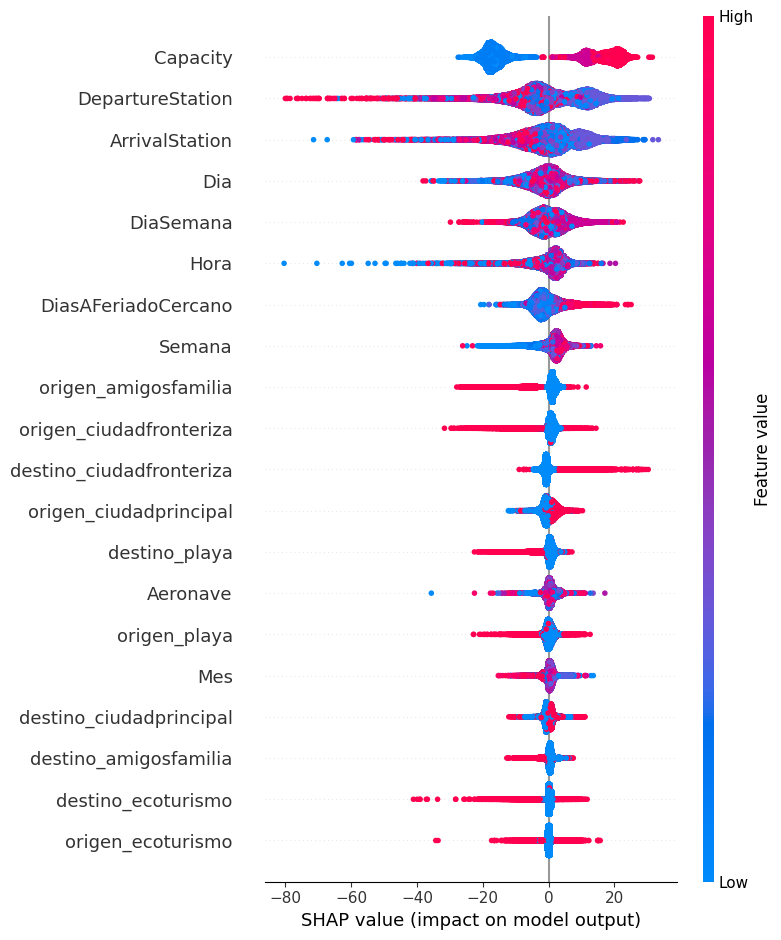

In [21]:
explainer = shap.TreeExplainer(xgb_r)
shap_values = explainer.shap_values(train_x)
shap.summary_plot(shap_values, train_x)

In [27]:
y.describe()

count    121724.000000
mean        183.721288
std          37.566481
min           1.000000
25%         162.000000
50%         185.000000
75%         211.000000
max         271.000000
Name: Passengers, dtype: float64

In [28]:
from sklearn.metrics import root_mean_squared_error

root_mean_squared_error(y_true=test_y, y_pred=y_pred)

21.887157